In [1]:
import os
import pathlib

# Set the working directory to be the parent of the cwd
os.chdir(pathlib.Path(os.getcwd()).parent)
cwd = os.getcwd()
print(cwd)

c:\Users\gipop\Desktop\Bocconi\4-Courses\20878-ComputerVision\21-eyes


## Imports

In [2]:

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchsummary import summary
import torchvision
from utils import CustomDataset
import wandb
import yaml

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

Device: cpu


In [3]:
CONFIG = {
    "architecture"  : "yoloV1",
    "batch_size"    : 64,
    "epochs"        : ...,
    "lr"            : ...,
    "optimizer"     : "SGD",
    "momentum"      : 0.9,
    "weight_decay"  : 0.0005,
    "p_dropout"     : 0.5,
    "scheduler"     : "ReduceLROnPlateau",
}

## Datasets and dataloaders

In [5]:
classes_path = os.path.join("configurations", "classes.yaml")
with open(classes_path, "r") as f:
    classes_yaml = yaml.safe_load(f)

CLASSES = classes_yaml["classes"]
NUM_CLASSES = len(CLASSES)

In [10]:
train_data = CustomDataset(
    images_dir=os.path.join(cwd, "data", "train", "images"),
    labels_dir=os.path.join(cwd, "data", "train", "labels"),
    classes=CLASSES,
    transform=None,
    input_size=(448, 448)
)

train_loader = DataLoader(
    dataset=train_data,
    batch_size=CONFIG["batch_size"],
    num_workers=8,
    shuffle=True,
    pin_memory=True
)

development_data = CustomDataset(
    images_dir=os.path.join(cwd, "data", "development", "images"),
    labels_dir=os.path.join(cwd, "data", "development", "labels"),
    classes=CLASSES,
    transform=None,
    input_size=(448, 448)
)

development_loader = DataLoader(
    dataset=development_data,
    batch_size=CONFIG["batch_size"],
    num_workers=8,
    shuffle=False
)

# TODO: Load the test data

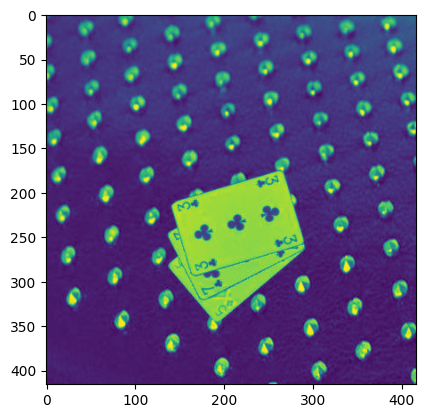

In [60]:
plt.imshow(train_loader.dataset[1][0][0])

In [61]:
train_loader.dataset[1][2]

tensor([[17,  4,  1],
        [24,  6,  0],
        [ 8,  2,  0],
        [ 8,  2,  0]])

In [62]:
CLASSES[17]

'6D'

In [ ]:
train_loader.dataset[1][0][1].shape

torch.Size([416, 416])

In [11]:
for i, (img, img_class) in enumerate(train_loader):

    print(f"Image shape: {img.shape}")
    break

RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "c:\Users\gipop\Desktop\Bocconi\4-Courses\20878-ComputerVision\21-eyes\.venv-21-eyes\Lib\site-packages\torch\utils\data\_utils\worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\gipop\Desktop\Bocconi\4-Courses\20878-ComputerVision\21-eyes\.venv-21-eyes\Lib\site-packages\torch\utils\data\_utils\fetch.py", line 55, in fetch
    return self.collate_fn(data)
           ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\gipop\Desktop\Bocconi\4-Courses\20878-ComputerVision\21-eyes\.venv-21-eyes\Lib\site-packages\torch\utils\data\_utils\collate.py", line 398, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\gipop\Desktop\Bocconi\4-Courses\20878-ComputerVision\21-eyes\.venv-21-eyes\Lib\site-packages\torch\utils\data\_utils\collate.py", line 212, in collate
    collate(samples, collate_fn_map=collate_fn_map)
  File "c:\Users\gipop\Desktop\Bocconi\4-Courses\20878-ComputerVision\21-eyes\.venv-21-eyes\Lib\site-packages\torch\utils\data\_utils\collate.py", line 155, in collate
    return collate_fn_map[elem_type](batch, collate_fn_map=collate_fn_map)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\gipop\Desktop\Bocconi\4-Courses\20878-ComputerVision\21-eyes\.venv-21-eyes\Lib\site-packages\torch\utils\data\_utils\collate.py", line 272, in collate_tensor_fn
    return torch.stack(batch, 0, out=out)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: stack expects each tensor to be equal size, but got [3, 4] at entry 0 and [4, 4] at entry 1


## Architecture

In [ ]:
class ConvolutionBlock(nn.Module):

    def __init__(self, in_c, channels, kernels, strides, pool):
        super(ConvolutionBlock, self).__init__()

        convolutions = [nn.Conv2d(
            in_channels=in_c,
            out_channels=channels[0],
            kernel_size=kernels[0],
            stride=strides[0],
            padding=kernels[0]//2
            ),
            nn.LeakyReLU(negative_slope=0.1)
        ]
        if len(channels) > 1:
            for i in range(len(channels)-1):
                convolutions.append(nn.Conv2d(
                in_channels=channels[i],
                out_channels=channels[i+1],
                kernel_size=kernels[i+1],
                stride=strides[i+1],
                padding=kernels[i+1]//2
                ))
                convolutions.append(nn.LeakyReLU(negative_slope=0.1))
        
        if pool:
            convolutions.append(nn.MaxPool2d(
            kernel_size=pool[0],
            stride=pool[1]
            ))

        self.convolutions = nn.Sequential(*convolutions)


    def forward(self, x):
        return self.convolutions(x)

In [ ]:
class Mlp(nn.Module):

    def __init__(self, in_size, hidden_sizes, out_size):
        super(Mlp, self).__init__()

        fully_connected = [
            nn.Linear(
                in_features=in_size,
                out_features=hidden_sizes[0]
            ),
            nn.LeakyReLU(negative_slope=0.1)
        ]
        
        if len(hidden_sizes) > 1:
            for i in range(len(hidden_sizes)-1):
                fully_connected.append(nn.Linear(
                    in_features=hidden_sizes[i],
                    out_features=hidden_sizes[i+1]
                ))
                fully_connected.append(nn.LeakyReLU(negative_slope=0.1))

        fully_connected.append(nn.Linear(
            in_features=hidden_sizes[-1],
            out_features=out_size
        ))

        self.fully_connected = nn.Sequential(*fully_connected)
    
    
    def forward(self, x):
        return self.fully_connected(x)

In [ ]:
class YoloV1(nn.Module):

    def __init__(self, convolution_blocks, mlp):
        super(YoloV1, self).__init__()

        self.convolutions = nn.ModuleList(
            [
                ConvolutionBlock(
                    in_c=block["in_c"],
                    channels=block["channels"],
                    kernels=block["kernels"],
                    strides=block["strides"],
                    pool=block["pool"]
                ) for block in convolution_blocks
            ]
        )

        self.pool_flatten = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten()
        )

        self.mlp = mlp
    
    
    def forward(self, x):
        for conv in self.convolutions:
            x = conv(x)
        x = self.pool_flatten(x)
        x = self.mlp(x)

        return x

In [ ]:
YOLO_PARAMS = {
    "S": 7, # Grid cells
    "B": 2, # Bounding boxes per each cell
    "C": 52 # Classes
}
OUTPUT_SIZE = YOLO_PARAMS["S"]*YOLO_PARAMS["S"] * (YOLO_PARAMS["B"]*5 + YOLO_PARAMS["C"])

convolution_list = [
    {
        "in_c": 3,
        "channels": [64],
        "kernels": [7],
        "strides": [2],
        "pool": [2, 2]
    },
    {
        "in_c": 64,
        "channels": [192],
        "kernels": [3],
        "strides": [1],
        "pool": [2, 2]
    },
    {
        "in_c": 192,
        "channels": [128, 256, 256, 512],
        "kernels": [1, 3, 1, 3],
        "strides": [1, 1, 1, 1],
        "pool": [2, 2]
    },
    {
        "in_c": 512,
        "channels": [256, 512]*4 + [512, 1024],
        "kernels": [1, 3]*4 + [1, 3],
        "strides": [1, 1]*4 + [1, 1],
        "pool": [2, 2]
    },
    {
        "in_c": 1024,
        "channels": [512, 1024]*2 + [1024, 1024],
        "kernels": [1, 3]*2 + [3, 3],
        "strides": [1, 1]*2 + [1, 2],
        "pool": False
    },
    {
        "in_c": 1024,
        "channels": [1024, 1024],
        "kernels": [3, 3],
        "strides": [1, 1],
        "pool": False
    },
]


mlp_dict = {
    "in_size": 1024,
    "hidden_sizes": [4096],
    "out_size": OUTPUT_SIZE
}

In [83]:
yolo_v1 = YoloV1(
    convolution_blocks=convolution_list,
    mlp=Mlp(
        in_size=mlp_dict["in_size"],
        hidden_sizes= mlp_dict["hidden_sizes"],
        out_size=mlp_dict["out_size"]
    )
).to(DEVICE)

summary(yolo_v1, (3, 448, 448), device=DEVICE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           9,472
         LeakyReLU-2         [-1, 64, 224, 224]               0
         MaxPool2d-3         [-1, 64, 112, 112]               0
  ConvolutionBlock-4         [-1, 64, 112, 112]               0
            Conv2d-5        [-1, 192, 112, 112]         110,784
         LeakyReLU-6        [-1, 192, 112, 112]               0
         MaxPool2d-7          [-1, 192, 56, 56]               0
  ConvolutionBlock-8          [-1, 192, 56, 56]               0
            Conv2d-9          [-1, 128, 56, 56]          24,704
        LeakyReLU-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
        LeakyReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]          65,792
        LeakyReLU-14          [-1, 256,

- Add padding to images to get shape 448x448